In [1]:
#Importing the basic Libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset
df = pd.read_csv('AirPassengers.csv')
df.Month = df.Month.apply(lambda x : dt(int(x[:4]),int(x[5:]),15))
df.set_index('Month',inplace=True)
original_df = df.copy(deep=True)
display(df.head())

,Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


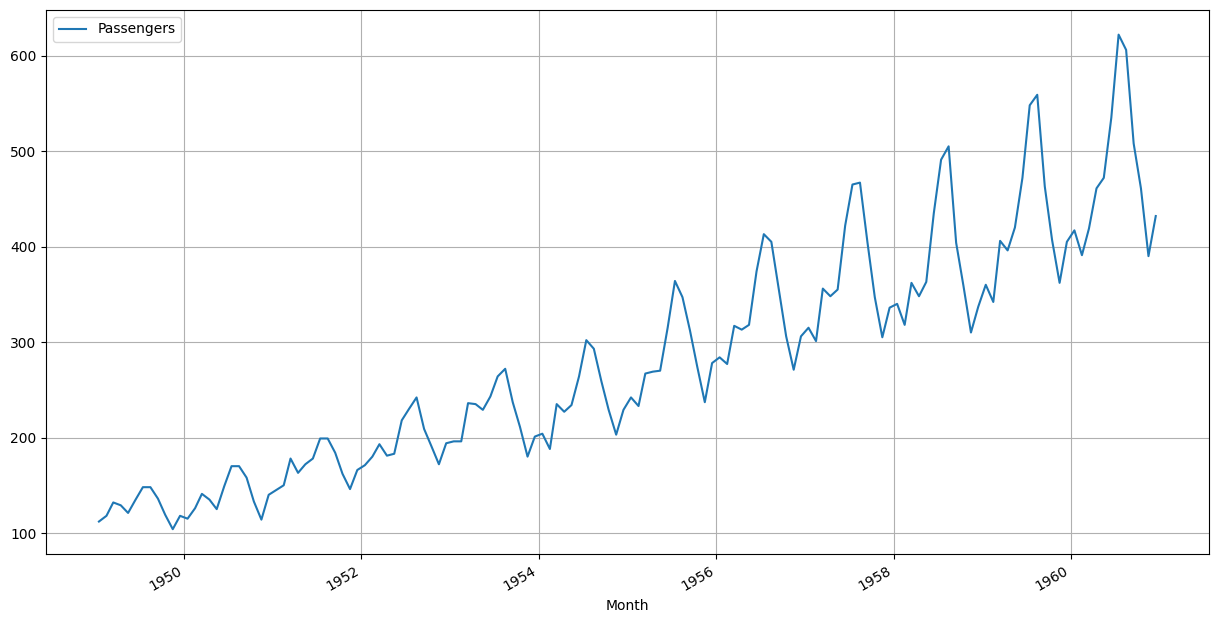

In [5]:
#Plotting the Data

df.plot()
plt.grid()
plt.show()

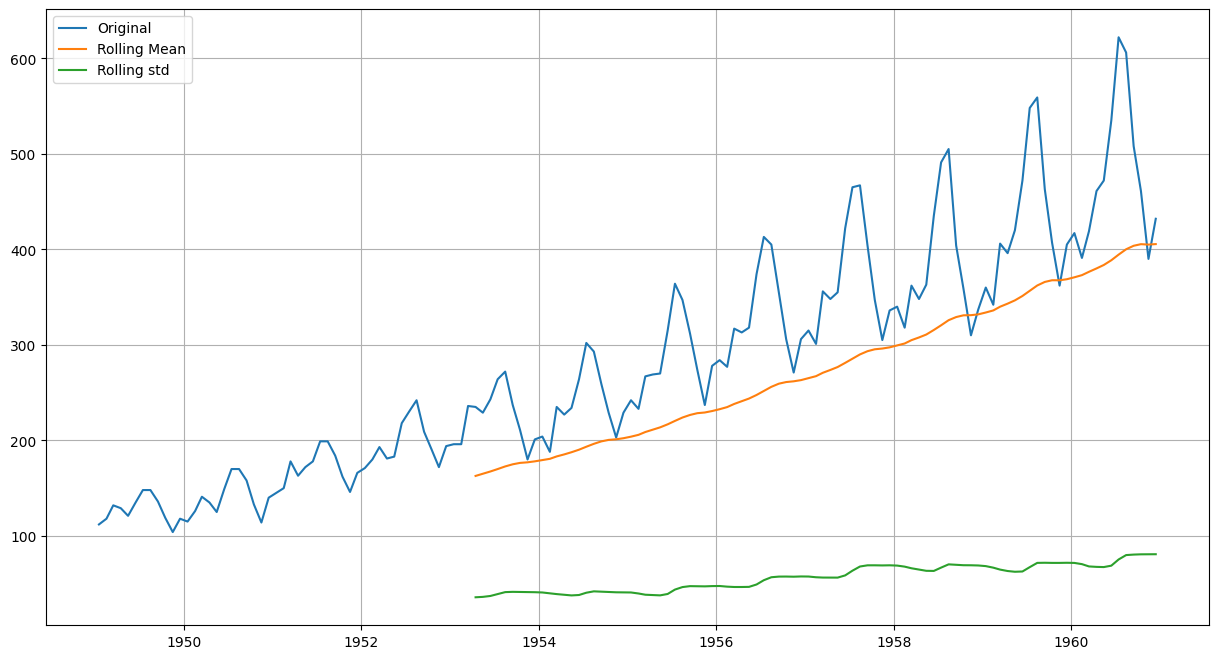

T Statistic             0.815369
P-Value                 0.991880
Lags Used              13.000000
Observations Used     130.000000
Critical value 1%      -3.481682
Critical value 5%      -2.884042
Critical value 10%     -2.578770
dtype: float64


In [9]:
#Stationary Check

from statsmodels.tsa.stattools import adfuller 

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52,center=False).std(), label='Rolling std')
    plt.grid()
    plt.legend()
    plt.show()

    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4],index=['T Statistic','P-Value','Lags Used','Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
Staionarity_Check(df['Passengers'])

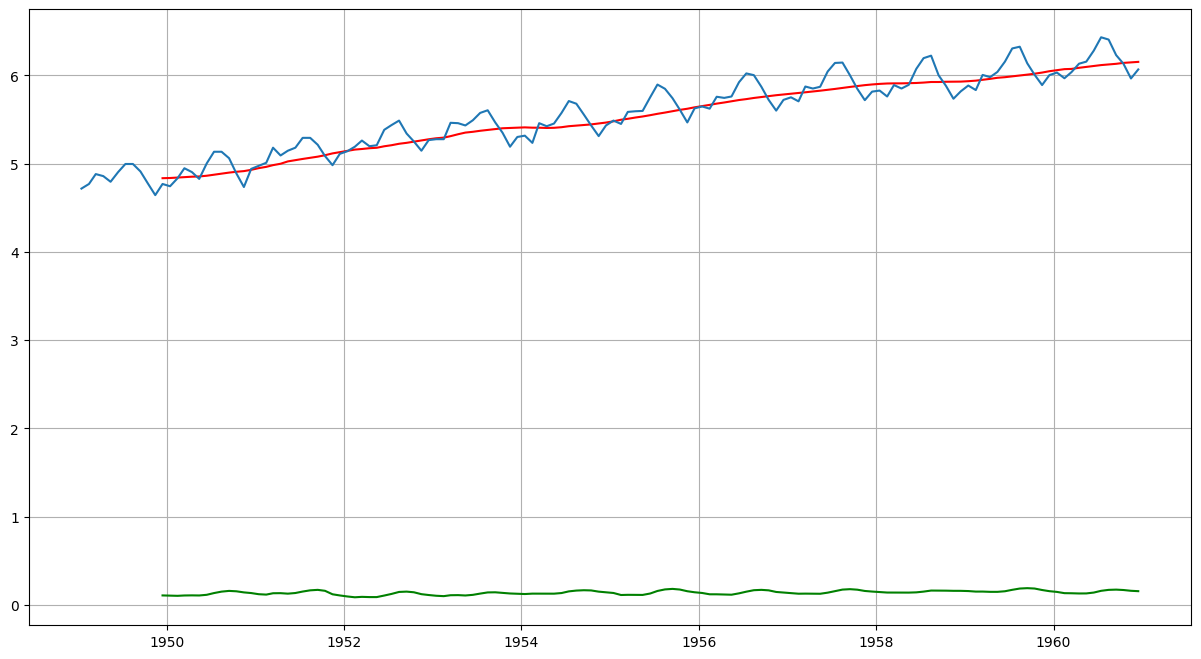

In [10]:
#Decoposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=12).mean()
ms = tsl.rolling(window=12).std()

plt.plot(ma, c='r')#, center=False
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

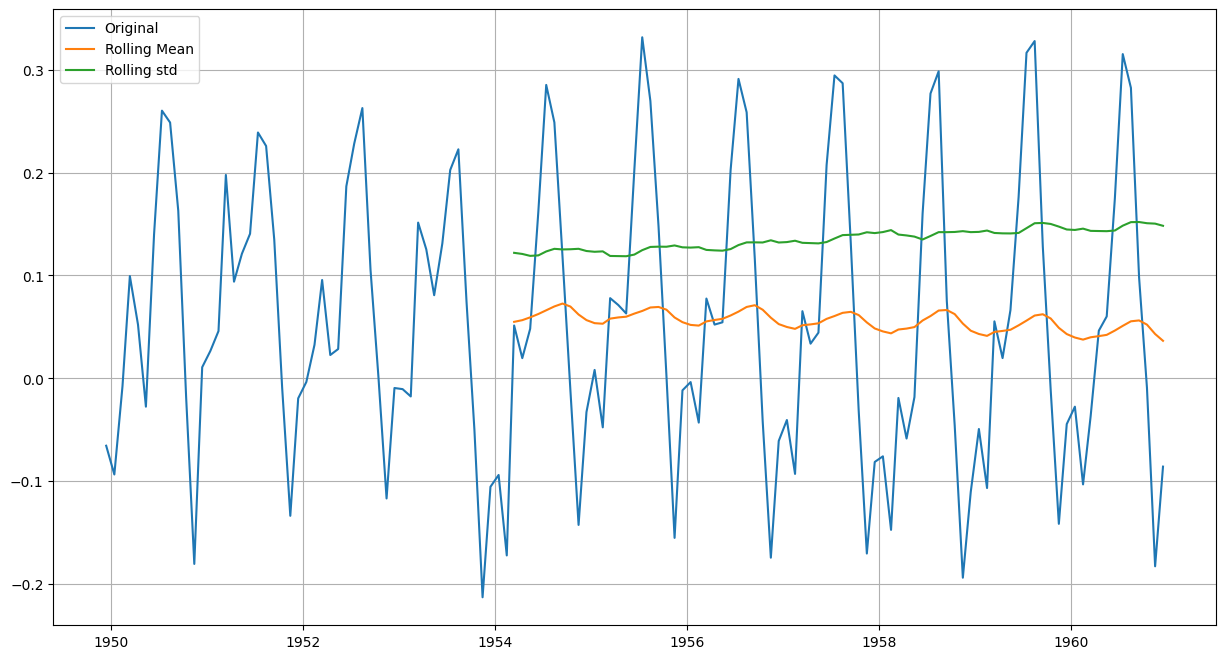

T Statistic            -3.162908
P-Value                 0.022235
Lags Used              13.000000
Observations Used     119.000000
Critical value 1%      -3.486535
Critical value 5%      -2.886151
Critical value 10%     -2.579896
dtype: float64


In [12]:
#Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=12, center=False).mean()

tskma = tsl - ma
tslma = tskma.dropna()
Staionarity_Check(tslma)


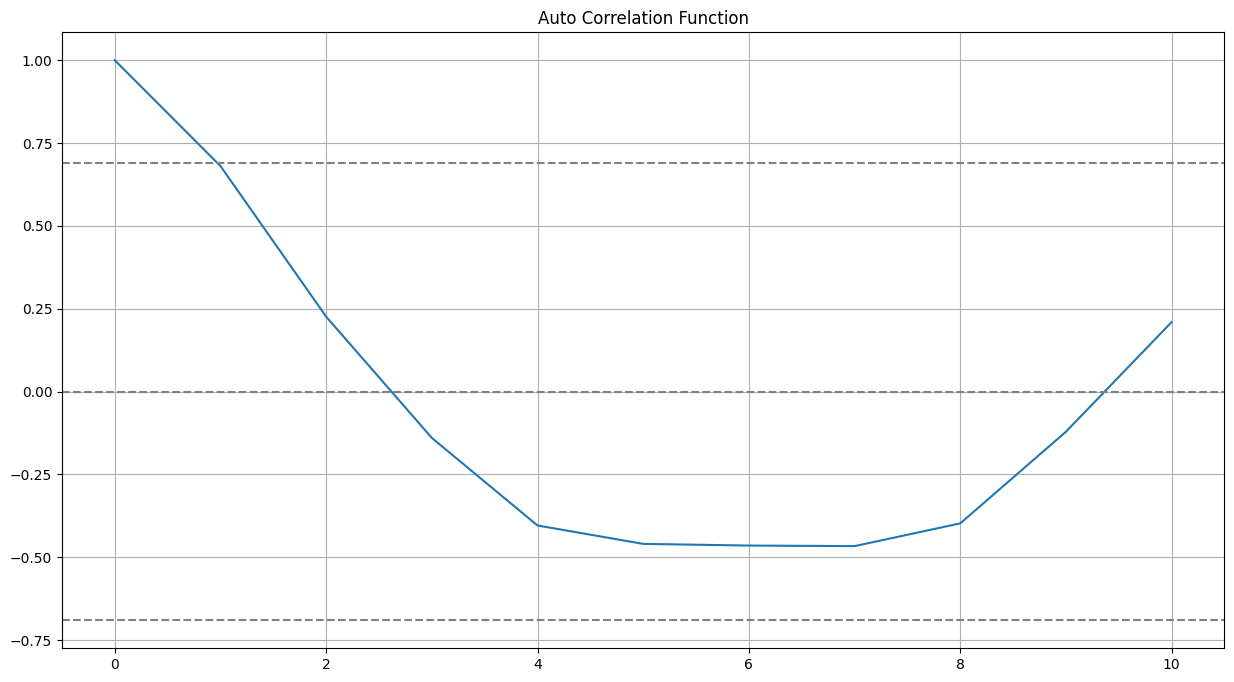

In [16]:
#Auto Correlation Function 

from statsmodels.tsa.stattools import acf, pacf
plt.plot(np.arange(acf(tslma, nlags=10, fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Function')
plt.grid()
plt.show()

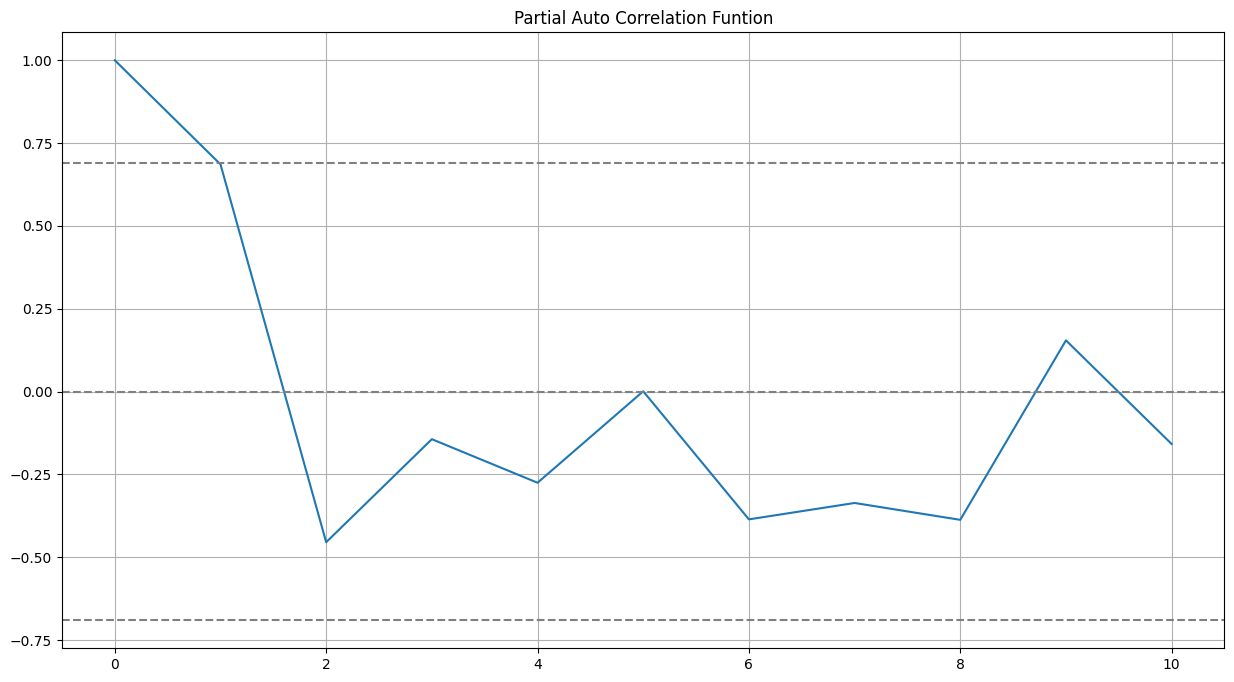

In [17]:
#Partial Auto Correlation Function 

from statsmodels.tsa.stattools import acf, pacf
plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Funtion')
plt.grid()
plt.show()

C:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  133
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 116.431
Date:                Thu, 16 May 2024   AIC                           -226.861
Time:                        17:59:39   BIC                           -218.213
Sample:                             0   HQIC                          -223.347
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5899      0.137     -4.301      0.000      -0.859      -0.321
ma.L1          0.8980      0.074     12.208      0.000       0.754       1.042
sigma2         0.0100      0.002      5.696      0.000       0.007       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.91   Prob(JB):                         0.07
Heteroskedasticity (H):               1.24   Skew:                            -0.01
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

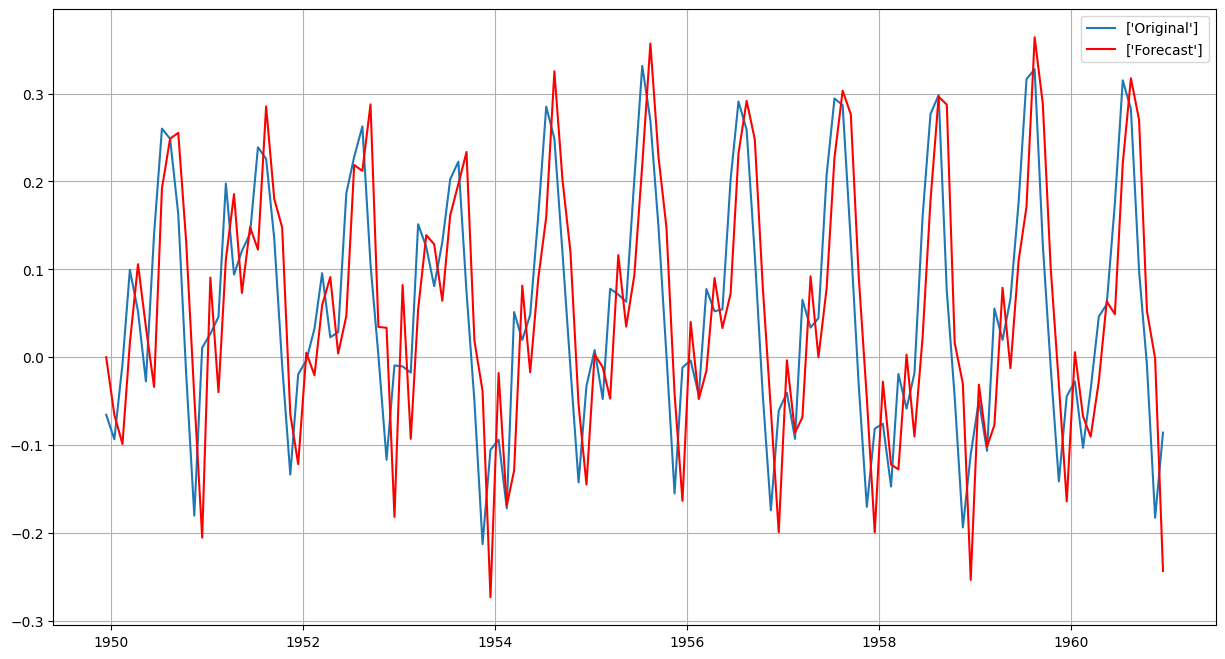

In [18]:
#Building ARIMA Model

from statsmodels.tsa.arima.model import ARIMA

Arima = ARIMA(tslma, order=(1,1,1))
Ar = Arima.fit()
plt.plot(tslma, label=['Original'])
plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
plt.legend()
plt.grid()

Ar.summary()


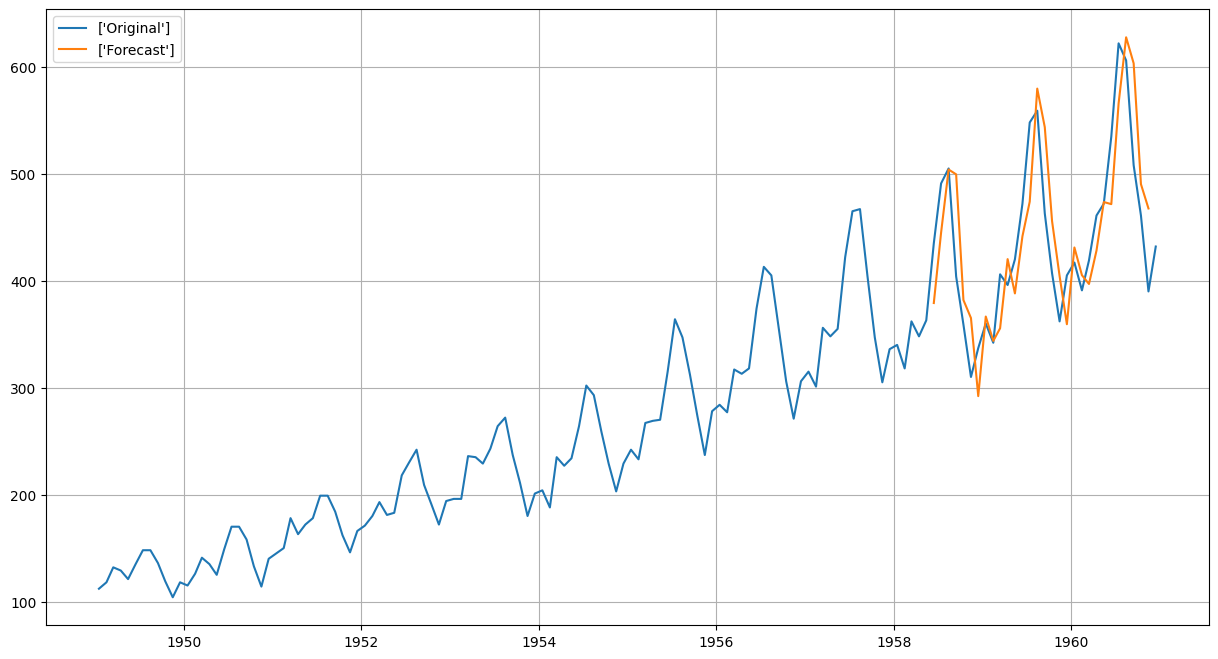

In [19]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Passengers'] = Ar.predict(start = 102, end = 131, dynamic = False)

plt.plot(df, label=['Original'])
plt.plot(np.exp(future_df+ma), label = ['Forecast'])
plt.grid()
plt.legend()
plt.show()